# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from  sklearn.ensemble import IsolationForest
from sklearn import metrics 
from sklearn import preprocessing 

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [ ]:
#df = pd.read_csv('bank_fin.csv', sep = ';')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
df = pd.read_csv('/content/drive/My Drive/project_4/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [4]:
#Получим долю пропусков в каждом столбце.
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)
# у нас в колонке balance есть пропуски в соотношении 0.22% от общего количества

balance    0.223974
dtype: float64

### Задание 2

In [ ]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [ ]:
# -1 - количество пропущенных значений больше 70%
df['pdays'].value_counts(normalize=True)

-1      0.745744
 92     0.009497
 182    0.007973
 91     0.007526
 181    0.007257
          ...   
 437    0.000090
 728    0.000090
 518    0.000090
 828    0.000090
 118    0.000090
Name: pdays, Length: 472, dtype: float64

In [ ]:
# unknown - количество пропущенных значений больше 70%
df['poutcome'].value_counts(normalize=True)

unknown    0.745924
failure    0.110016
success    0.095951
other      0.048110
Name: poutcome, dtype: float64

In [ ]:
# 0 - нулевой результат прошлой компании больше 70%
df['previous'].value_counts(normalize=True)[:5]

0    0.745744
1    0.079466
2    0.062086
3    0.038972
4    0.021860
Name: previous, dtype: float64

*Вывод: Скорее всего признаки pdays и poutcome коллинеарны с previous*

### Задание 3

In [28]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def get_balance(arg):
  arg = str(arg).replace(' ', '')
  arg = arg.replace('$', '')
  return float(arg.replace(',', '.'))
df['balance'] = df['balance'].apply(get_balance)
print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [29]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
balance_mean = round(df['balance'].median(), 3)
df['balance'].fillna(balance_mean, inplace=True)
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [30]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
mode_job = df['job'].mode()[0]
df['job'].replace('unknown', mode_job, inplace=True)

mode_education = df['education'].mode()[0]
df['education'].replace('unknown', mode_education, inplace=True)

In [31]:
pop_job = df['job'].value_counts().index[0]
pop_edu = df['education'].value_counts().index[0]

df.loc[(df['education']==pop_edu)&(df['job']==pop_job)]['balance'].mean()

1598.8829787234042

### Задание 6

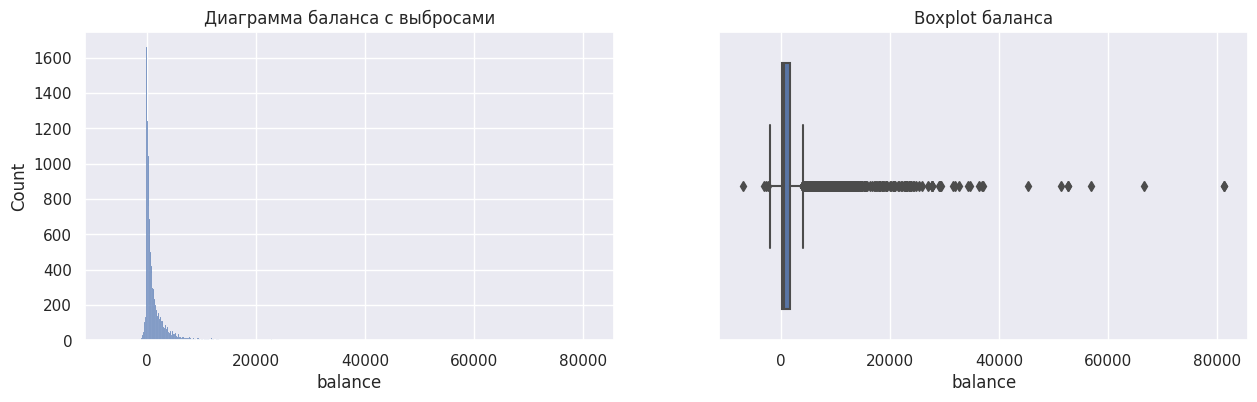

In [32]:
# выбросы для признака balance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Диаграмма баланса с выбросами');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Boxplot баланса');

-2241.0
4063.0


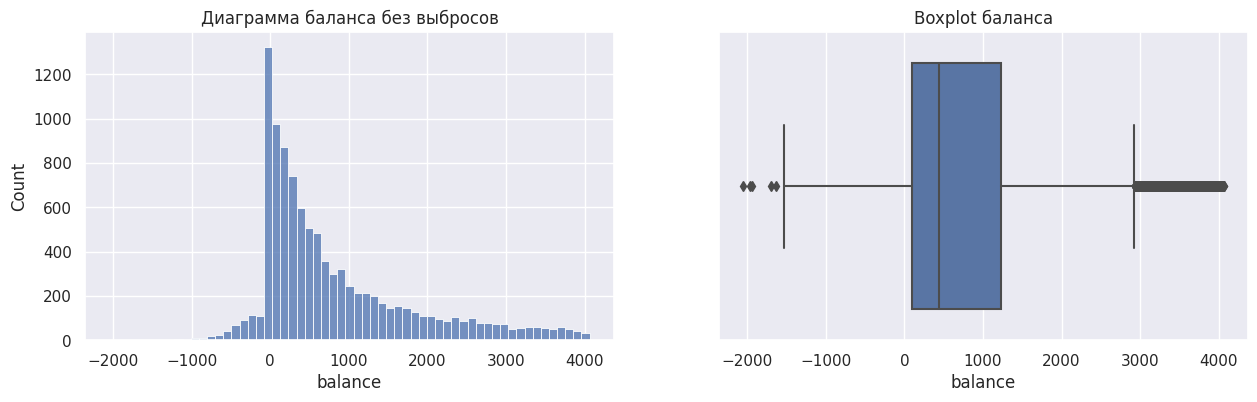

In [33]:
# удалите все выбросы для признака balance
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    print(lower_bound)
    print(upper_bound)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(df, 'balance')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Диаграмма баланса без выбросов');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Boxplot баланса');

In [11]:
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


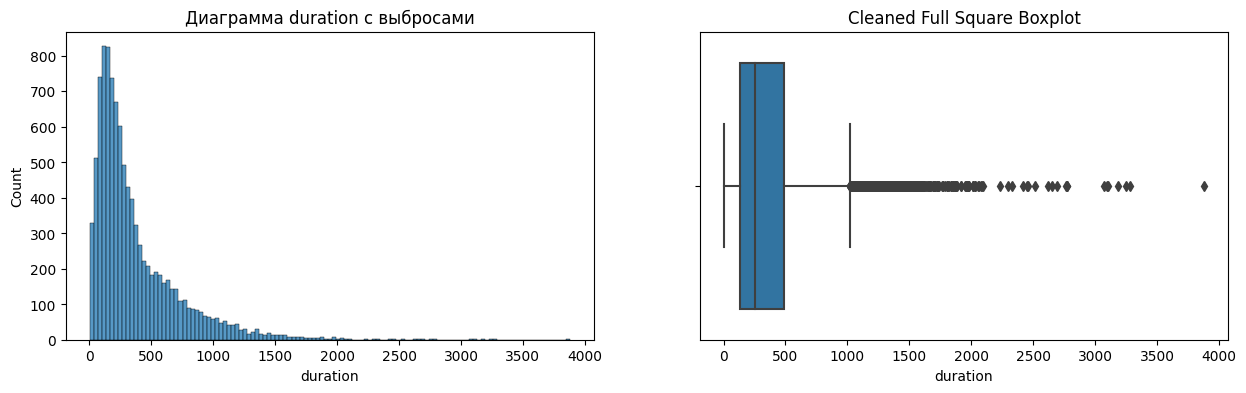

In [12]:
# выбросы для признака duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='duration', ax=axes[0]);
histplot.set_title('Диаграмма duration с выбросами');
boxplot = sns.boxplot(data=cleaned, x='duration', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

-392.5
1019.5


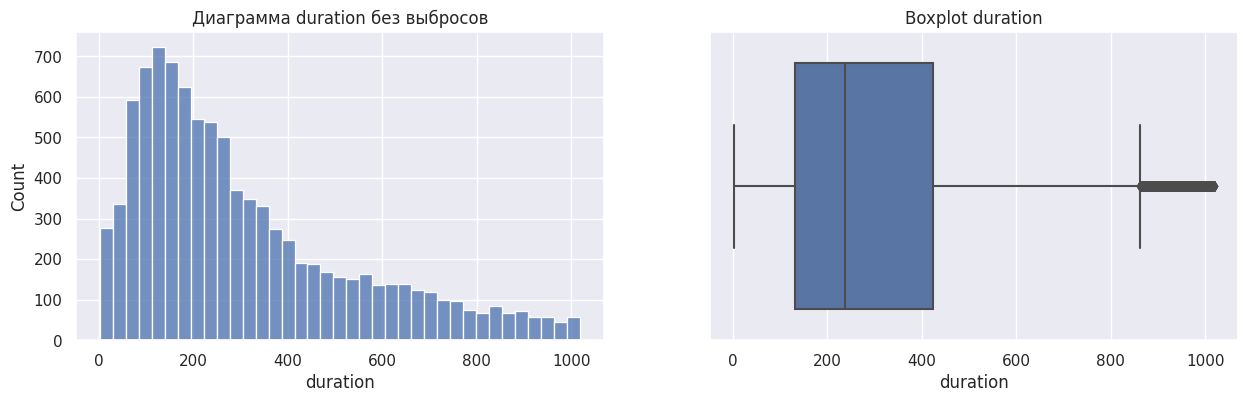

In [34]:
# удалите все выбросы для признака duration
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    print(lower_bound)
    print(upper_bound)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(cleaned, 'duration')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='duration', ax=axes[0]);
histplot.set_title('Диаграмма duration без выбросов');
boxplot = sns.boxplot(data=cleaned, x='duration', ax=axes[1]);
boxplot.set_title('Boxplot duration');

In [14]:
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 591
Результирующее число записей: 9514


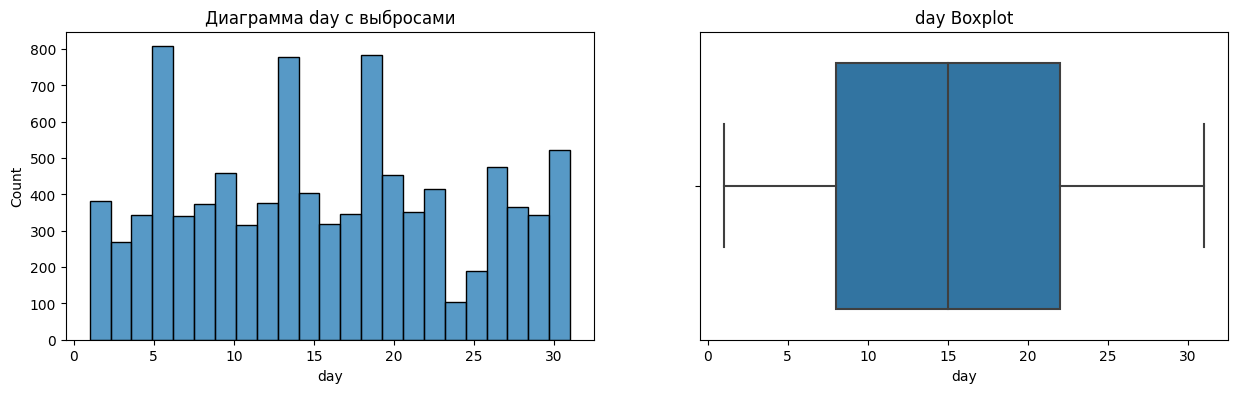

In [15]:
# выбросы для признака day
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='day', ax=axes[0]);
histplot.set_title('Диаграмма day с выбросами');
boxplot = sns.boxplot(data=cleaned, x='day', ax=axes[1]);
boxplot.set_title('day Boxplot');

*Выбросов нет*

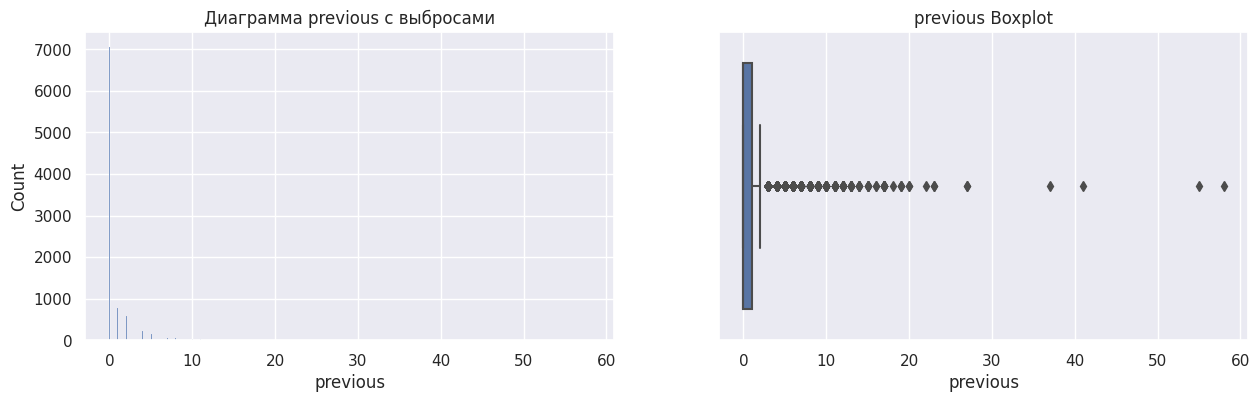

In [35]:
# выбросы для признака previous
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='previous', ax=axes[0]);
histplot.set_title('Диаграмма previous с выбросами');
boxplot = sns.boxplot(data=cleaned, x='previous', ax=axes[1]);
boxplot.set_title('previous Boxplot');

*Вывод: количество контактов до текущей компании можно ограничить до 3 контактов, а остальное задать как категорию '>3'*

In [36]:
# записываем previous>3, как 4 с последующим dummies
def get_previous(arg):
    if arg>3:
      return '>3'
    else:
      return arg

cleaned['previous'] = cleaned['previous'].apply(get_previous)

# создание дамми-переменных
cleaned = pd.get_dummies(cleaned, columns=['previous'])

In [18]:
cleaned.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,poutcome,deposit,previous_0,previous_1,previous_2,previous_3,previous_>3
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,...,579,1,-1,unknown,yes,1,0,0,0,0
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,...,673,2,-1,unknown,yes,1,0,0,0,0


In [37]:
# ищем дупликаты
dupl_columns = list(cleaned.columns)

mask = cleaned.duplicated(subset=dupl_columns)
df_duplicates = cleaned[mask]
print(f'Число найденных дубликатов: {df_duplicates.shape[0]}')

Число найденных дубликатов: 0


In [38]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in cleaned.columns:
    #наибольшая относительная частота в признаке
    top_freq = cleaned[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = cleaned[col].nunique() / cleaned[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

default: 98.3% одинаковых значений
previous_3: 96.03% одинаковых значений


*Вывод: default (имеется ли просроченный кредит) - имеет 98.3% одинаковых значений 'no'*

## Часть 2:  Разведывательный анализ

### Задание 1

no     5368
yes    4146
Name: deposit, dtype: int64

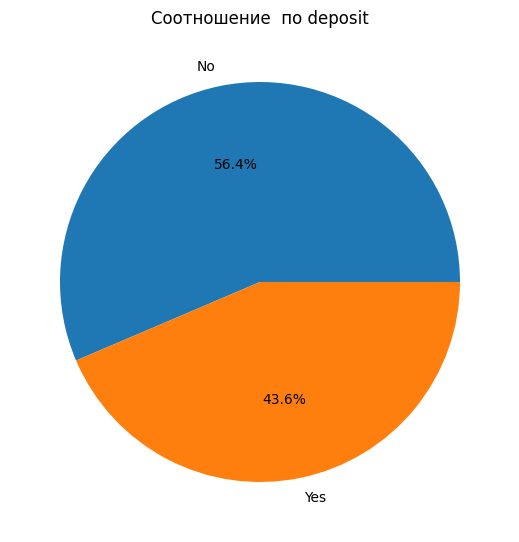

In [21]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

exited = cleaned['deposit'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    exited,
    labels=['No', 'Yes'],
    autopct='%.1f%%'
)
axes.set_title('Cоотношение  по deposit');
exited

*Вывод: Класс сбалансирован*

### Задания 2 и 3

In [39]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = cleaned.dtypes
num_features = list(types[(types != 'object')].index)
num_features
cleaned[num_features].describe()

,age,balance,day,duration,campaign,pdays,previous_0,previous_1,previous_2,previous_3,previous_>3
count,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000
mean,40.928211,805.229136,15.602796,307.402354,2.504099,52.497898,0.741959,0.080513,0.062329,0.039731,0.075468
std,11.803304,994.598902,8.467498,233.822852,2.725971,110.545355,0.437580,0.272100,0.241765,0.195337,0.264158
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,94.000000,8.000000,131.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,440.000000,15.000000,237.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,49.000000,1220.750000,22.000000,423.000000,3.000000,50.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,95.000000,4063.000000,31.000000,1019.000000,43.000000,854.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Задания 4 и 5

12
11


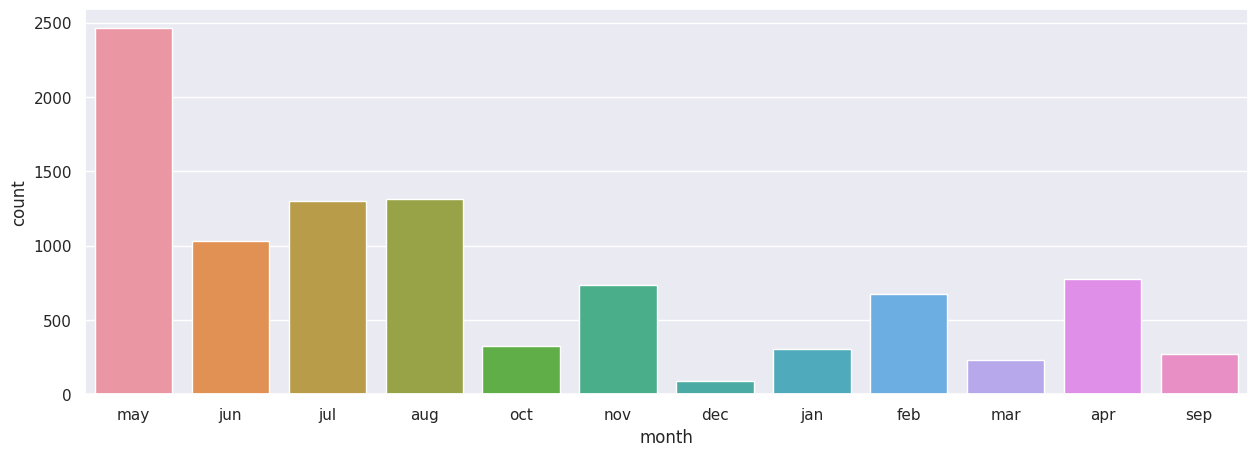

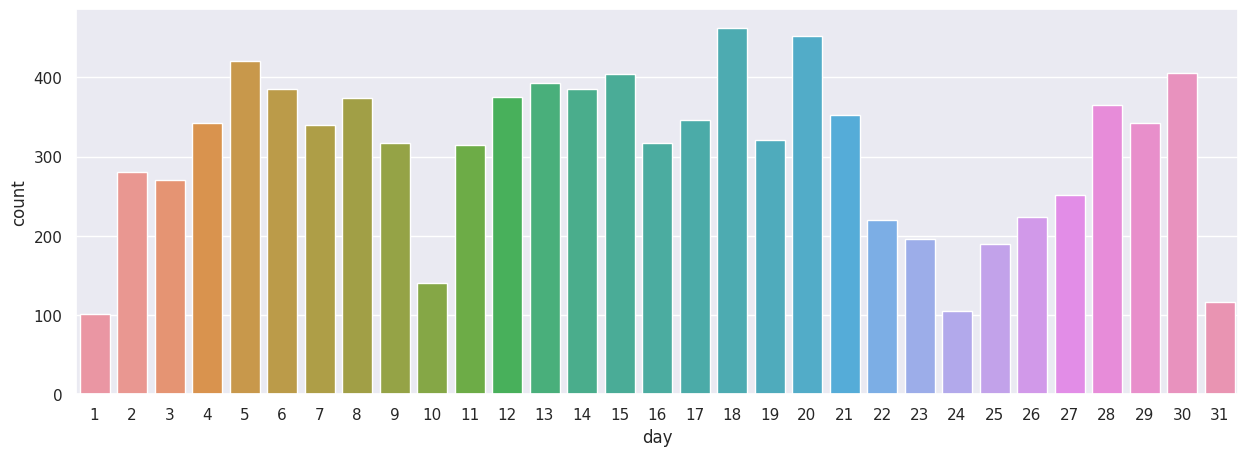

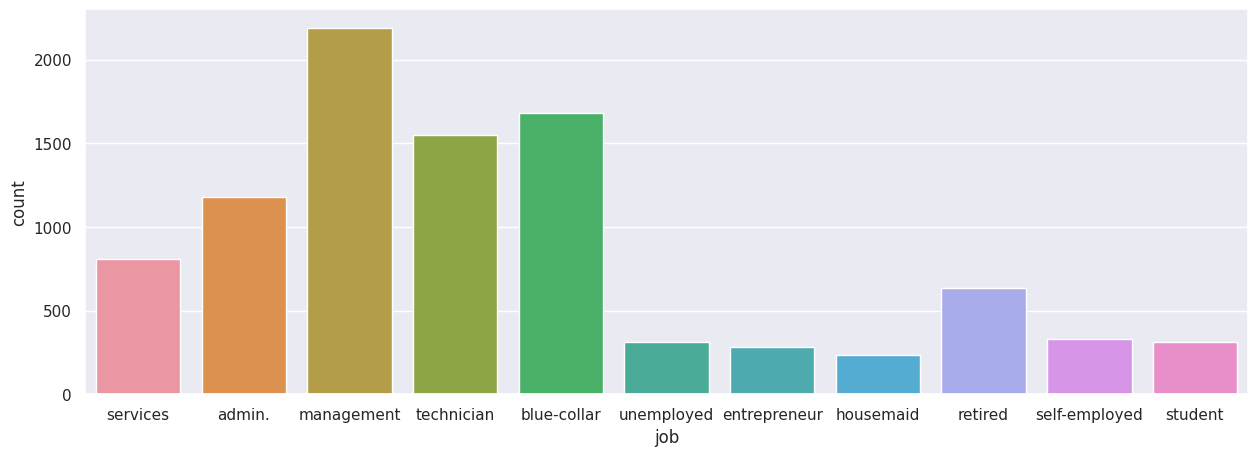

In [40]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
print(cleaned['month'].value_counts().count())
print(cleaned['job'].value_counts().count())

sns.set(style='darkgrid')
plt.figure(figsize=(15,5))
ax = sns.countplot(x='month', data=cleaned)

sns.set(style='darkgrid')
plt.figure(figsize=(15,5))
ax = sns.countplot(x='day', data=cleaned)

sns.set(style='darkgrid')
plt.figure(figsize=(15,5))
ax = sns.countplot(x='job', data=cleaned)

### Задание 6

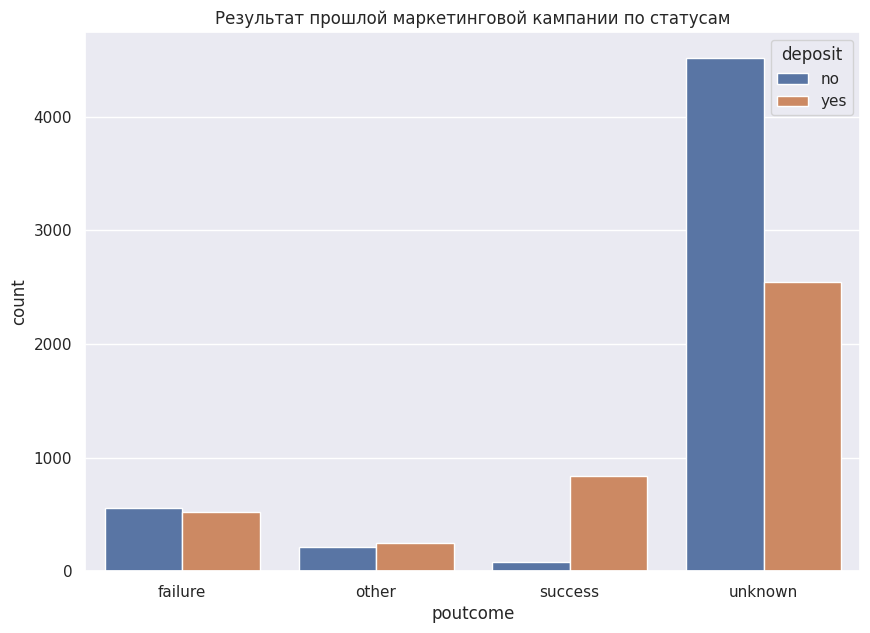

In [24]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
clean_group = cleaned.groupby(['poutcome'], as_index=False)['deposit'].value_counts()

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=clean_group,
    x='poutcome',
    y='count',
    hue='deposit',
)
barplot.set_title('Результат прошлой маркетинговой кампании по статусам');

*Вывод: В статусе success успех превалирует в предыдущей компании*

### Задание 7

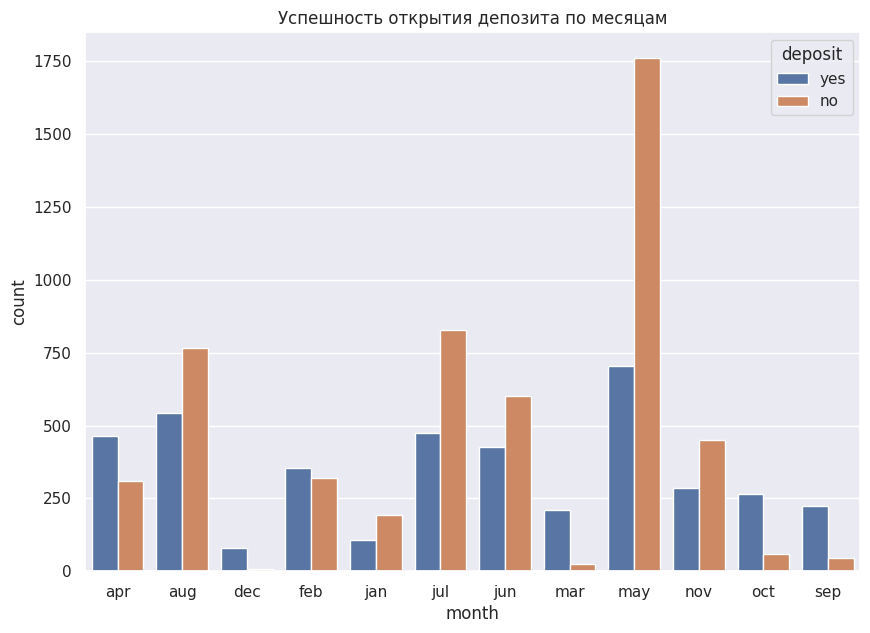

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
cleaned.loc[cleaned['deposit']=='no']['month'].value_counts()

clean_group = cleaned.groupby(['month'], as_index=False)['deposit'].value_counts()

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=clean_group,
    x='month',
    y='count',
    hue='deposit',
)
barplot.set_title('Успешность открытия депозита по месяцам');

### Задание 8

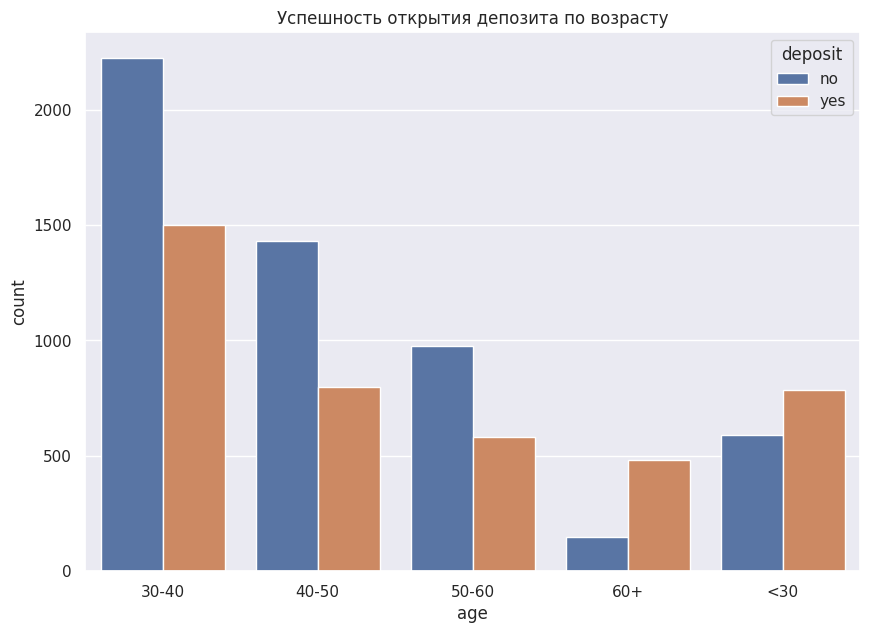

In [41]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly
import plotly.express as px

def get_sezon(arg):
    if arg<30:
      return '<30'
    elif arg>=30 and arg<40:
      return '30-40'
    elif arg>=40 and arg<50:
      return '40-50'
    elif arg>=50 and arg<60:
      return '50-60'
    else:
      return '60+'


cleaned['age'] = cleaned['age'].apply(get_sezon)


clean_group = cleaned.groupby(['age'], as_index=False)['deposit'].value_counts()

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=clean_group,
    x='age',
    y='count',
    hue='deposit',
)
barplot.set_title('Успешность открытия депозита по возрасту');

### Задания 9 и 10

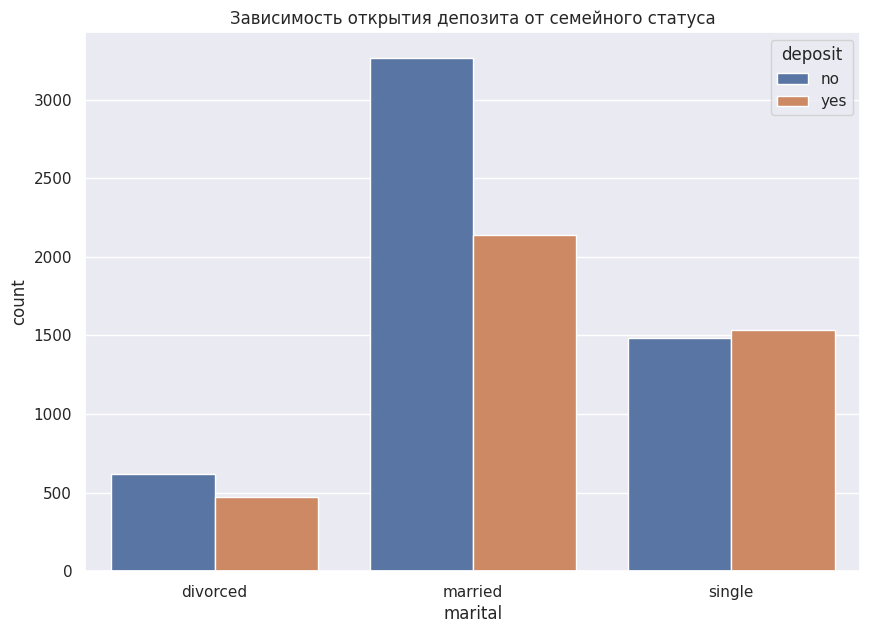

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
clean_group = cleaned.groupby(['marital'], as_index=False)['deposit'].value_counts()

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=clean_group,
    x='marital',
    y='count',
    hue='deposit',
)
barplot.set_title('Зависимость открытия депозита от семейного статуса');

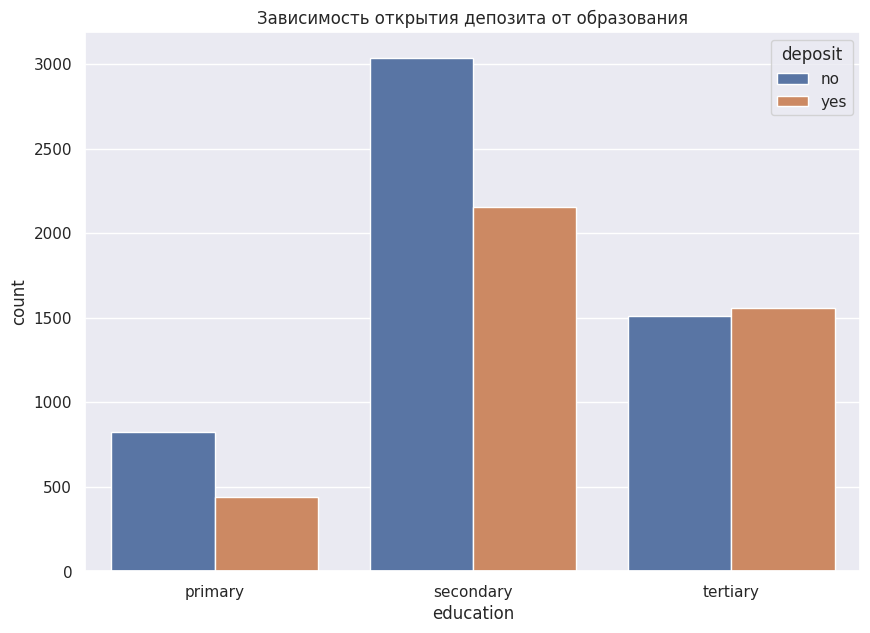

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
clean_group = cleaned.groupby(['education'], as_index=False)['deposit'].value_counts()

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=clean_group,
    x='education',
    y='count',
    hue='deposit',
)
barplot.set_title('Зависимость открытия депозита от образования');

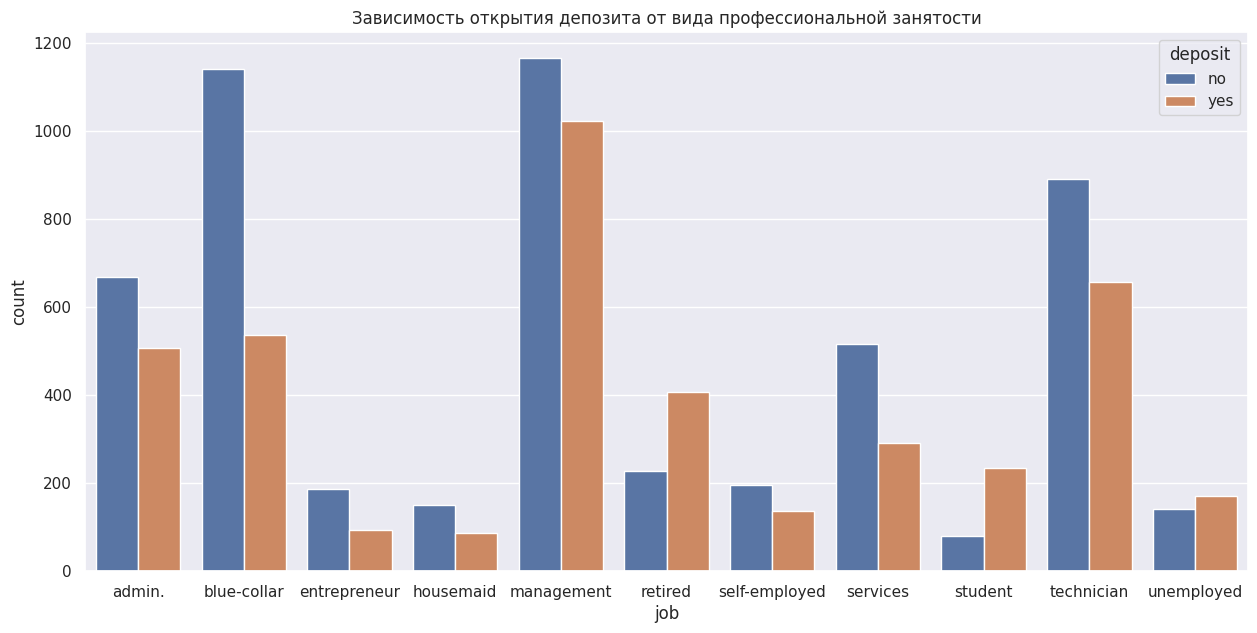

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
clean_group = cleaned.groupby(['job'], as_index=False)['deposit'].value_counts()


fig = plt.figure(figsize=(15, 7))
barplot = sns.barplot(
    data=clean_group,
    x='job',
    y='count',
    hue='deposit',
)
barplot.set_title('Зависимость открытия депозита от вида профессиональной занятости');

### Задание 11

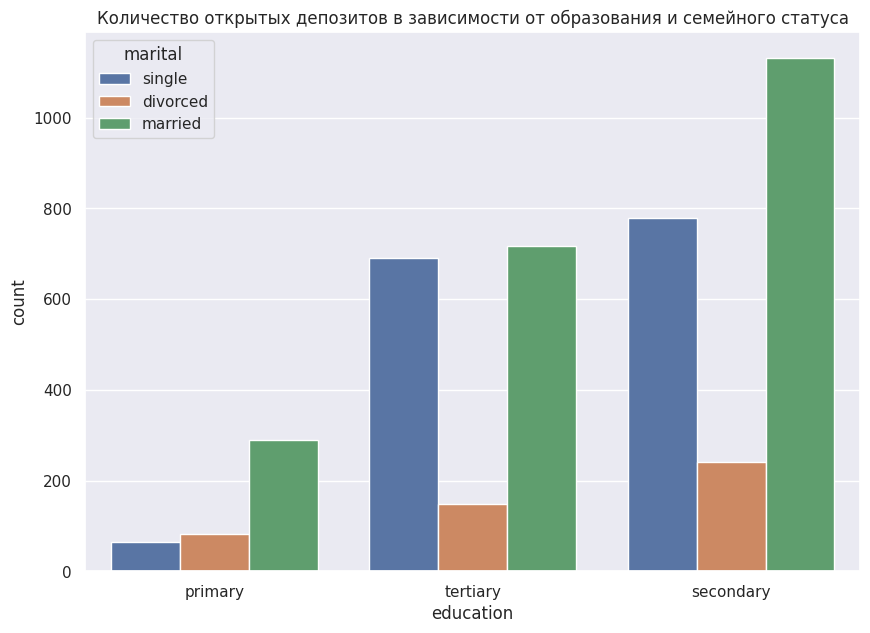

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

clean_group = cleaned.groupby(['education', 'marital'], as_index=False)['deposit'].value_counts().sort_values('count')

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=clean_group[clean_group['deposit']=='yes'],
    x='education',
    y='count',
    hue='marital',
)
barplot.set_title('Количество открытых депозитов в зависимости от образования и семейного статуса');

## Часть 3: преобразование данных

### Задание 1

In [42]:
# преобразуйте уровни образования
from sklearn.preprocessing  import LabelEncoder
 
le = LabelEncoder()

le.fit(cleaned['education'])
 
print('категории:', le.classes_)
 
cleaned['education'] = le.transform(cleaned['education'])

категории: ['primary' 'secondary' 'tertiary']


In [43]:
# преобразуйте уровни возраста
from sklearn.preprocessing  import LabelEncoder
 
le = LabelEncoder()

le.fit(cleaned['age'])
 
print('категории:', le.classes_)
 
cleaned['age'] = le.transform(cleaned['age'])

категории: ['30-40' '40-50' '50-60' '60+' '<30']


### Задания 2 и 3

In [44]:
# преобразуйте бинарные переменные в представление из нулей и единиц
from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()

lb.fit(cleaned['deposit'])
 
print('категории:', lb.classes_)
 
cleaned['deposit'] = lb.transform(cleaned['deposit'])
cleaned['deposit'].std()

категории: ['no' 'yes']


0.4958845535562679

In [45]:
from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()

lb.fit(cleaned['default'])
 
print('категории:', lb.classes_)
 
cleaned['default'] = lb.transform(cleaned['default'])


from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()

lb.fit(cleaned['housing'])
 
print('категории:', lb.classes_)
 
cleaned['housing'] = lb.transform(cleaned['housing'])


from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()

lb.fit(cleaned['loan'])
 
print('категории:', lb.classes_)
 
cleaned['loan'] = lb.transform(cleaned['loan'])

cleaned['loan'].mean() + cleaned['housing'].mean() + cleaned['default'].mean()

категории: ['no' 'yes']
категории: ['no' 'yes']
категории: ['no' 'yes']


0.6278116459953752

### Задание 4

In [46]:
# создайте дамми-переменные
cleaned = pd.get_dummies(cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

In [ ]:
cleaned.shape

(9514, 48)

### Задания 5 и 6

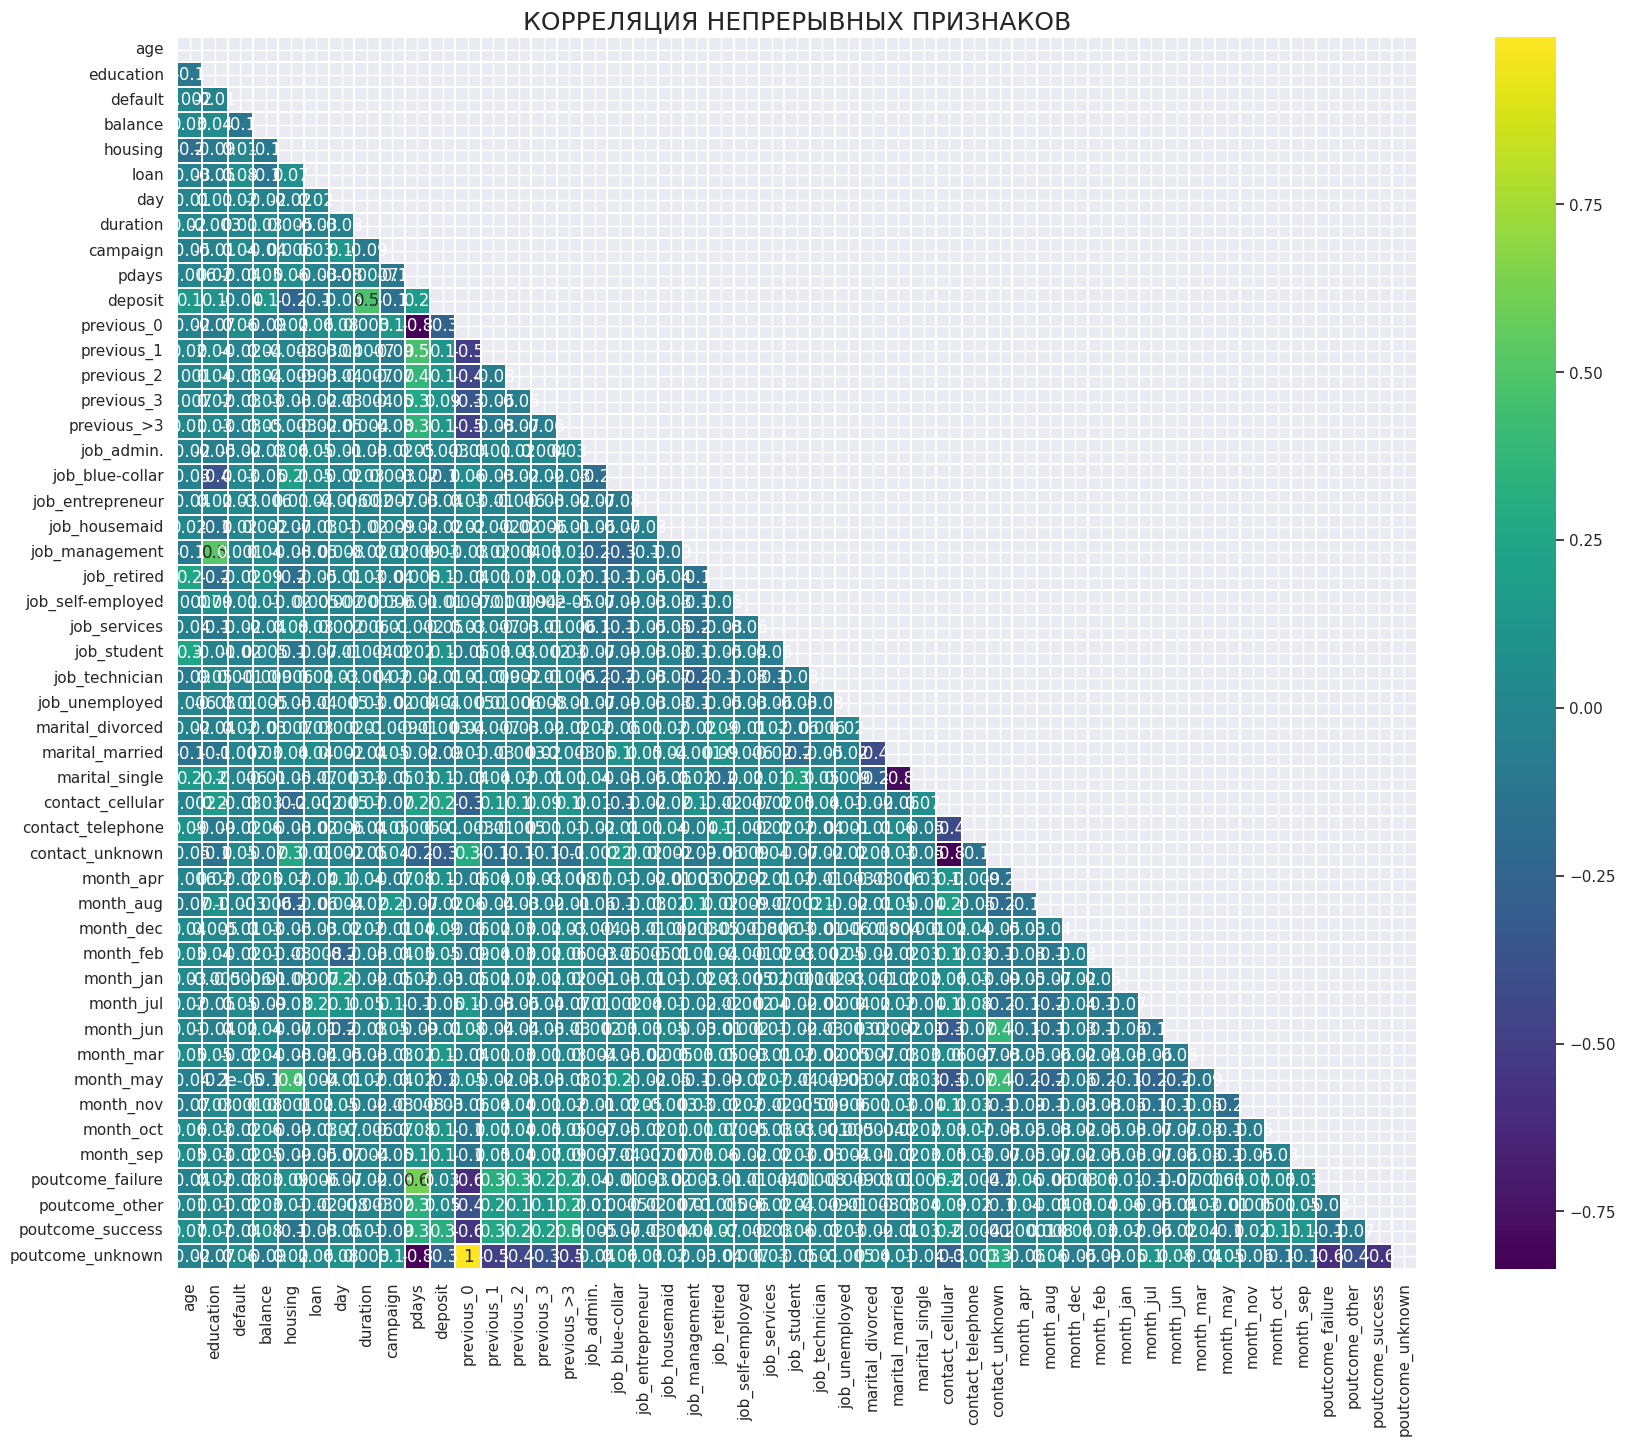

In [47]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
#функция построения корреляционной диаграммы
def show_corr_heatmap(data, columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(20, 16))
    corr = data[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

num_cols = cleaned.columns
#строим диаграмму для непрерывных признаков:
show_corr_heatmap(cleaned, num_cols, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', method='pearson');

*Вывод: Видим мультиколлинеарность между previous_0 и poutcome_unknown*

In [48]:
cleaned.drop(['poutcome_unknown'], axis=1, inplace=True)

### Задания 7 и 8

In [49]:
X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [50]:
# рассчитайте необходимые показатели
X_test.shape


(3140, 47)

In [51]:
y_test.mean()

0.4356687898089172

### Задание 9

In [52]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
select_col = selector.get_feature_names_out()
X_train_sel = X_train[select_col]
X_test_sel = X_test[select_col]

In [ ]:
select_col

array(['age', 'balance', 'housing', 'duration', 'campaign', 'pdays',
       'previous_0', 'previous_>3', 'contact_cellular', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'month_sep',
       'poutcome_success'], dtype=object)

### Задание 10

In [53]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train_sel)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

In [54]:
X_test_scaled[0].mean()

0.19511850531118166

In [69]:
X_train_sel

,age,balance,housing,duration,campaign,pdays,previous_0,previous_>3,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success
4694,2,436.0,0,95,1,-1,1,0,0,1,1,0,0,0,0
3361,4,866.0,0,191,2,-1,1,0,1,0,1,0,0,0,0
3304,3,1644.0,0,341,4,179,0,1,0,0,1,0,0,0,1
7144,0,54.0,1,118,1,-1,1,0,1,0,0,0,0,0,0
1837,2,3025.0,0,476,1,352,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3658,0,718.0,1,271,1,84,0,0,1,0,0,0,0,0,1
6184,0,819.0,1,102,14,-1,1,0,0,0,0,0,0,0,0
6877,0,432.0,1,94,1,-1,1,0,0,1,0,0,0,0,0
5769,2,295.0,0,151,11,-1,1,0,1,0,0,0,0,0,0


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [56]:
# обучите логистическую регрессию и рассчитайте метрики качества


#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.78


### Задания 2,3,4

In [57]:
# обучите решающие деревья, настройте максимальную глубину
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy')
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.70


### Задание 5

In [58]:
from sklearn.model_selection import GridSearchCV
# подберите оптимальные параметры с помощью gridsearch
param_grid = {#'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7],
              'criterion': ['gini']
              }
            
grid_search_tree = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
%time 
grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 12.6 µs
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [59]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42, 
                                     n_estimators = 100, 
                                     criterion = 'gini',
                                     min_samples_leaf = 5,
                                     max_depth = 10
                                     )

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Recall test: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train: 0.83
Test: 0.80
Recall test: 0.81


### Задания 2 и 3

In [60]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
### Прописываем параметры для нашей модели 
from sklearn.ensemble import GradientBoostingClassifier
params = {'n_estimators':200,
          'max_depth':12,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16
          }


### Тренируем
gbr = GradientBoostingClassifier(**params)
gbr.fit(X_train_scaled, y_train)
y_train_pred = gbr.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = gbr.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.93
Test: 0.79


In [61]:
y_train_pred

array([1, 1, 1, ..., 0, 0, 1])

### Задание 4

In [62]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

params = {'n_estimators':200,
          'max_depth':12,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16
          }
param_dtr = {'criterion': 'gini', 
            'max_depth': 7, 
            'min_samples_split': 5
    
}
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(random_state=42,  **param_dtr)),
    ('lr', LogisticRegression(solver = 'sag', random_state=42)),
    
    ('gbr', GradientBoostingClassifier(**params))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=LogisticRegression( #метамодель
        solver = 'sag',
        #n_estimators=10, #количество деревьев в ансамбле                    
        random_state=42 #датчик генератора случайных чисел
    )
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для стекинга {round(metrics.precision_score(y_test, y_pred_stack), 2)}')

Качество предсказания по MSE для стекинга 0.79


### Задание 5

[0.05175695 0.12616648 0.04330089 0.42578732 0.03192873 0.05141144
 0.01018894 0.00224085 0.00441392 0.07915276 0.02948284 0.01351391
 0.01594787 0.00636737 0.10833971]


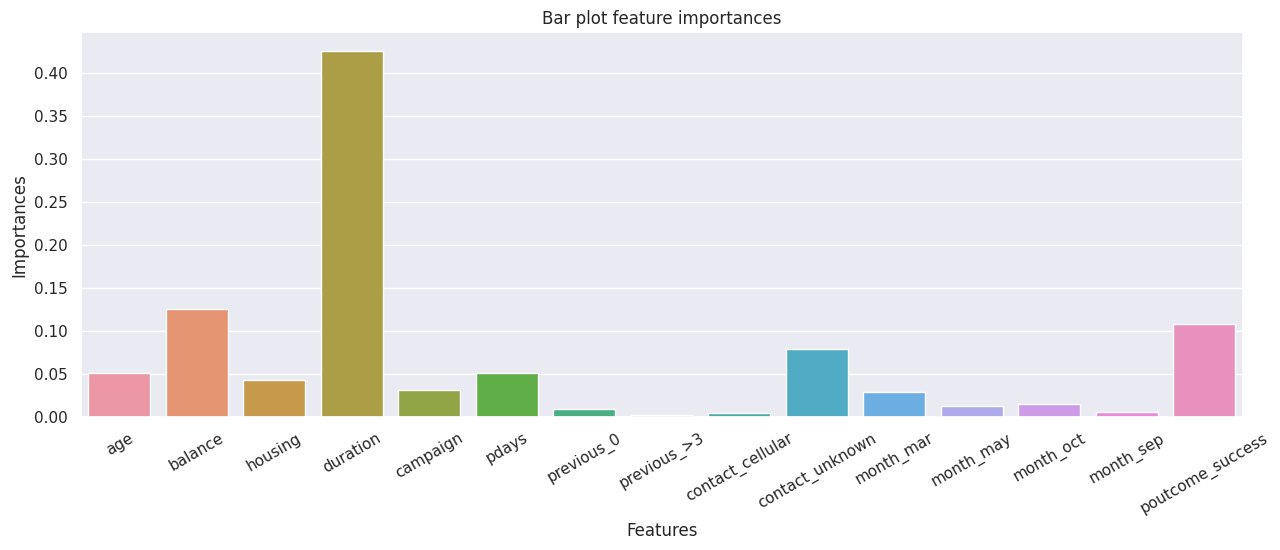

In [74]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
print(gbr.feature_importances_)

fig, ax = plt.subplots(figsize=(15, 5)) #фигура + координатная плоскость
feature = X_train_sel.columns #признаки
feature_importances = gbr.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);

plt.xticks(rotation=30)
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

### Задания 6,7,8

In [75]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.8 MB/s eta 0:00:00


In [76]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
random_state = 42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  

#%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-05-31 06:15:38,733] A new study created in memory with name: RandomForestClassifier
[I 2023-05-31 06:15:40,663] Trial 0 finished with value: 0.836603638958259 and parameters: {'n_estimators': 187, 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.836603638958259.
[I 2023-05-31 06:15:41,839] Trial 1 finished with value: 0.8283662477558348 and parameters: {'n_estimators': 152, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.836603638958259.
[I 2023-05-31 06:15:42,654] Trial 2 finished with value: 0.8779007497322384 and parameters: {'n_estimators': 106, 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8779007497322384.
[I 2023-05-31 06:15:43,327] Trial 3 finished with value: 0.8289000718907261 and parameters: {'n_estimators': 102, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8779007497322384.
[I 2023-05-31 06:15:44,198] Trial 4 finished with value: 0.8384683882457702 and parameters: {'n_e

Наилучшие значения гиперпараметров {'n_estimators': 129, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.80


In [77]:
# доступна ли поддержка визуализации?
optuna.visualization.is_available()

True

In [78]:
# График истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name="f1_score")


In [79]:
# График важности гиперпараметров 
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [81]:
# График контура отношений гиперпараметров
optuna.visualization.plot_contour(study, 
target_name="f1_score")